# Visual Question Answering challenge for ANNDL 2019-2020

Made by :

LEADERBOARD NICKNAME : 10527332_10527346

NAME_1: Mattia

LAST-NAME_1: Mancassola

STUDENT-ID_1:10527332

NAME_2: Daniele

LAST-NAME_2: Parravicini

STUDENT-ID_2 :10527346

We used Kaggle to train and evaluate our models.

We kept a validation dataset percentage at 20% for most of the models under consideration. More details about dataset split used for the last models are contained in the notebook.

## Workflow:
We started with a simple model in which:
- tokenized text was transformed by an embedding and then fed into an LSTM
- image was fed into a CNN
their outputs were then concatenated and fed into a dense layer that was in charge to feed the output neurons which then tackle the problem as a standard classification using softmax.

Different changes have been applied to this basic architecture, both on the CNN and the LSTM. Actually, we mainly focused on the LSTM, since it seemed that the convolutional part was not crucial. Thus we tried switching from LSTM to GRU and also a Bidirectional structure. We also tried different methods to merge the textual features and the convolutional ones, by using the layers provided by Keras, like 'average()', 'dot()' etc., in addition to the 'concatenate()'. However, no improvements were noticed.

As a second step, we took into consideration the idea of creating a model able to distinguish between counting and existential questions. Thanks to that the model would have been able to tackle:
- the first questions as a regression problem, which is expected to be more suitable for a counting questions
- while the second type of questions will be handled as a standard classification problem (yes/no)

Despite this, we struggled to achieve accuracy higher than .40, so we decided to experiment with pretrained components. In particular we tested different pretrained classification models, even if at the end the most accurate were found to be the simplest ones, like VGG16 and VGG19. Indeed, at the end we used VGG19 as feature extractor and Glove as Embedding. 

*Note: in order to use Glove we used the 'Add Data' button of Kaggle to add the following data:*
- https://www.kaggle.com/anindya2906/glove6b
- https://www.kaggle.com/au1206/20-newsgroup-original

With that setup, we considered different model structures to combine together information coming from the feature and the sequence of words that build up the question.

More precisely, we considered the following mechanisms:
- [Relational Networks](https://arxiv.org/pdf/1706.01427.pdf) (more on this in the notebook);
- Attention (Luong and Bahdanau) to build a more precise context value that would then be used to answer the question;
- Attention to select one or more features based on a comparison between global average pooling of the feature with the context value coming from an LSTM;
- Attention mechanism to select the most relevant feature vector in the feature maps.

As a last tentative we tried also to substitute Embedding with a **one-hot encoding** which was worth our highest score (0.49 in the validation set and a .523 on the test set).

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder

import json
import random
from datetime import datetime
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import re

print(tf.__version__)

In [ ]:
SEED = 2019
tf.random.set_seed(SEED)

classes = ['0',             # 0
           '1',             # 1
           '10',            # 2
           '2',             # 3
           '3',             # 4
           '4',             # 5
           '5',             # 6
           '6',             # 7
           '7',             # 8
           '8',             # 9
           '9',             # 10
           'no',            # 11
           'yes']           # 12

PATH = "/kaggle/input/ann-and-dl-vqa/dataset_vqa"

num_labels = 13
batch_size = 128

MAX_SEQUENCE_LENGTH = 43
IMG_HEIGHT, IMG_WIDTH = 128, 192
CLASSIFICATION = False
PRETRAINED_EMBEDDING = False
BALANCE_TRAIN_SET = True

## Load data from json files

In [ ]:
with open(os.path.join(PATH, 'train_data.json'), 'r') as f:
    train_data = json.load(f)
f.close()

with open(os.path.join(PATH, 'test_data.json'), 'r') as f:
    test_data = json.load(f)
f.close()

train_data = train_data['questions']
test_data = test_data['questions']

train_dataset_size = len(train_data) # number of questions --> 259492

### Speed up training
The training procedure was very slow and batch of 64 elements took 2 seconds to be processed. 
We suspected that most of the time during optimization was spent moving images from disk to the GPU, rather than computing activation functions and gradients over the model graph.
After reading [A simple neural network module
for relational reasoning](https://arxiv.org/pdf/1706.01427.pdf) it became clear that the task could be solved using images with lower resolution. 
For that reason we decided to:
- resize images to 128x192 (we also took advantage of kaggle hosting capabilities to store a static version of the resized images) 
- exploit caches offered by dataset shuffling

obtaining a result of 590 ms per batch of 128 elements (the batch size was increased since the image size was smaller).

In [ ]:
path = '/kaggle/input/ann-and-dl-vqa/dataset_vqa/'
writing_path = '/kaggle/working'
IMG_HEIGHT, IMG_WIDTH = 320, 480
scale_ratio = 0.4
IMG_HEIGHT, IMG_WIDTH = int(IMG_HEIGHT*scale_ratio), int(IMG_WIDTH * scale_ratio)
import os
if not (os.path.exists(os.path.join(writing_path , 'resized_test'))):
    os.mkdir(os.path.join(writing_path , 'resized_test'))

if not (os.path.exists(os.path.join(writing_path , 'resized_train'))):
    os.mkdir(os.path.join(writing_path , 'resized_train'))
    
img_to_resize = os.listdir(os.path.join(path, 'test'))

def resize_test(filename):
    if filename.endswith('.png'):
        source_path = os.path.join(path , 'test',filename)
        new_path = os.path.join(writing_path , 'resized_test',filename)
        if(os.path.exists(new_path)):
            return
        img = Image.open(source_path)
        img = img.resize((IMG_WIDTH,IMG_HEIGHT ))
        img = np.array(img)[:,:,:3]
        img = Image.fromarray(img, 'RGB')
        img.save(new_path, 'JPEG', quality=80)
        
def resize_train(filename):
    if filename.endswith('.png'):
        source_path = os.path.join(path , 'train',filename)
        new_path = os.path.join(writing_path , 'resized_train',filename)
        if(os.path.exists(new_path)):
            return
        img = Image.open(source_path)
        img = img.resize((IMG_WIDTH,IMG_HEIGHT ))
        img = np.array(img)[:,:,:3]
        img = Image.fromarray(img, 'RGB')
        img.save(new_path, 'JPEG', quality=80)
        
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool(10)
results = pool.map(resize_test, img_to_resize)

img_to_resize = os.listdir(os.path.join(path, 'train'))
results = pool.map(resize_train, img_to_resize)

assert( len(os.listdir(os.path.join(writing_path , 'resized_test')))/len( os.listdir(os.path.join(path, 'test'))) == 1)

# Data Generator

## Tokenizer
The tokenizer translates questions made of words into vectors of numbers.

Answers are preprocessed so as to divide punctuation from words by at least a space.
The number of terms that the tokenizer can encode has to be fixed before starting using it. For such a reason questions are extracted and fed into the tokenizer so that it can determine all the parameters that are necessary for its usage.

In [ ]:
def preprocess_words(string):
    # when we used Glove we had to substitute the term 'matte' with a 'opaque' which was instead present
    # in Glove indices
    return re.sub(r'matte', r'opaque', string)

for i,q in enumerate(train_data):
    train_data[i]['question'] = spreprocess_words(train_data[i]['question'].lower())

for i,q in enumerate(test_data):
    test_data[i]['question'] = preprocess_words(test_data[i]['question'].lower())

In [ ]:
texts    = [el['question']for el in train_data ]
texts.extend(el['question']for el in test_data )

max_words = max([len(line.split()) for line in texts])
MAX_SEQUENCE_LENGTH = max_words

In [ ]:
import sys
from tensorflow.keras.layers import Embedding

def getPretrainedEmbedding():
    
    BASE_DIR = '/kaggle/input/'
    GLOVE_DIR = os.path.join(BASE_DIR, 'glove6b')
    TEXT_DATA_DIR = os.path.join(BASE_DIR, '20-newsgroup-original', '20_newsgroup', '20_newsgroup')

    MAX_NUM_WORDS = 20000
    EMBEDDING_DIM = 100

    # first, build index mapping words in the embeddings set
    # to their embedding vector

    print('Indexing word vectors.')

    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    # second, prepare text samples and their labels
    print('Processing text dataset')

    texts = []  # list of text samples
    labels_index = {}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    for name in sorted(os.listdir(TEXT_DATA_DIR)):
        path = os.path.join(TEXT_DATA_DIR, name)
        if os.path.isdir(path):
            label_id = len(labels_index)
            labels_index[name] = label_id
            for fname in sorted(os.listdir(path)):
                if fname.isdigit():
                    fpath = os.path.join(path, fname)
                    args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                    with open(fpath, **args) as f:
                        t = f.read()
                        i = t.find('\n\n')  # skip header
                        if 0 < i:
                            t = t[i:]
                        texts.append(t)
                    labels.append(label_id)

    print('Found %s texts.' % len(texts))

    # finally, vectorize the text samples into a 2D integer tensor
    t = Tokenizer(num_words=MAX_NUM_WORDS)
    t.fit_on_texts(texts)
    sequences = t.texts_to_sequences(texts)

    word_index = t.word_index
    print('Found %s unique tokens.' % len(word_index))

    print('Preparing embedding matrix.')

    # prepare embedding matrix
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    
        
    return t,embedding_layer


def getEmbedding():
    if PRETRAINED_EMBEDDING :
        return getPretrainedEmbedding()
    else:
        EMBEDDING_DIM = 10
        # check that all questions are made with terms that 
        # the embedding is able to use.
        texts    = [el['question']for el in train_data ]
        texts.extend(el['question']for el in test_data )

        max_words = max([len(line.split()) for line in texts])
        words = set( np.concatenate([line.split() for line in texts]))

        t = Tokenizer(num_words=len(words))
        t.fit_on_texts(texts)

        embedding_layer = Embedding(input_dim=len(words)+1,
                                    output_dim=EMBEDDING_DIM,
                                    input_length=MAX_SEQUENCE_LENGTH)
        return t, embedding_layer
        
t, embedding_layer = getEmbedding()

In [ ]:
# check that all questions are made with terms that the embedding is able to use.
texts    = [el['question']for el in train_data ]
texts.extend(el['question']for el in test_data )

max_words = max([len(line.split()) for line in texts])
words = set( np.concatenate([line.split() for line in texts]))
print('Found (',len(words),') words in our questions:',words)
print('Questions are at most ',max_words,' word long ')

for w in words:
    if (w in '.,:;!?'):
        continue
    if ( w not in t.word_index ):
        print(w)

### MyDataset
this class hides the steps that led to the dataset creation. This class is also thought to be responsible for the splitting of data between validation and training set.
This class can be supplied with:
- a predicate that filters the elements in json. It is used to acquire a subset of questions related to a certain answer
- a field that indicates what part of each object contained in json variable has to be taken
- a function 'funct' that is executed of the field extracted before building the dataset

In [ ]:
class myDataset(tf.data.Dataset):
   
    def __new__(self, json,  output_shapes, output_types, validation_split=0.0,field=None,
                seed=None, subset='training', funct = None, filt=None , verbose=False, randomize=True):
        
        #1. set seed if available
        if(seed is not None):
            tf.random.set_seed(SEED)
            np.random.seed(SEED)
        #2. divide questions in two sets randomly.
        #print(os.listdir(basepath))
           
        self.subset = json
        #if present use a filter
        if filt is not None:
            if(verbose):
                 print('executed: ',filt)
            self.subset = list(filter(filt, self.subset))
        
        if(randomize):
            np.random.shuffle(self.subset)

        split_indx = round( validation_split * len(self.subset) )
        #3. take the part corresponding to to either the validation
        # or the training subset
        if subset == 'validation':
            self.number_of_items = split_indx
            self.subset = self.subset[:split_indx]
            
            
        else :
            self.number_of_items =len(self.subset)- split_indx
            self.subset = self.subset[split_indx:]
            
        
        if(verbose):
            #print number of items carried
            print( self.number_of_items, 'items ingested')
            #print field
            print( 'taking field ', field)
        
                 
        #extract field from json
        if field is not None:
            self.subset = list(map(lambda el: el[field], self.subset))
        
        #define an high order function that will be passed 
        # to tf.data.Dataset.from_generator to obtain the dataset.
        def get_generator(funct, randomize):
            def generator(subset):
                
                res = subset
                
                if randomize:
                    np.random.shuffle(res)
                
                if funct is not None:
                    if(verbose):
                        print('executed:',funct)
                    res = map(funct, res)

                res = map(tf.convert_to_tensor, res)

                for el in iter(res):
                    yield el
                
            return generator
        
        generator = get_generator(funct, randomize)
        
        return self.number_of_items, tf.data.Dataset.from_generator(
            generator,
            output_types=output_types,
            output_shapes=output_shapes,
            args = (self.subset,)
        )
    
    def number_of_items(self):
        return self.number_of_items

### Create a evenly distributed dataset
To create a dataset that is not unbalanced w.r.t. the answers, in the initial steps we create different datasets for each answer. 
Those are later recombined using :
- [tf.data.experimental.sample_from_datasets](https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets?version=stable) to obtain a dataset with a known distribution  
- [choose_from_dataset](https://www.tensorflow.org/api_docs/python/tf/data/experimental/choose_from_datasets) to create batches with a uniform ditribution of answers in it. Result: 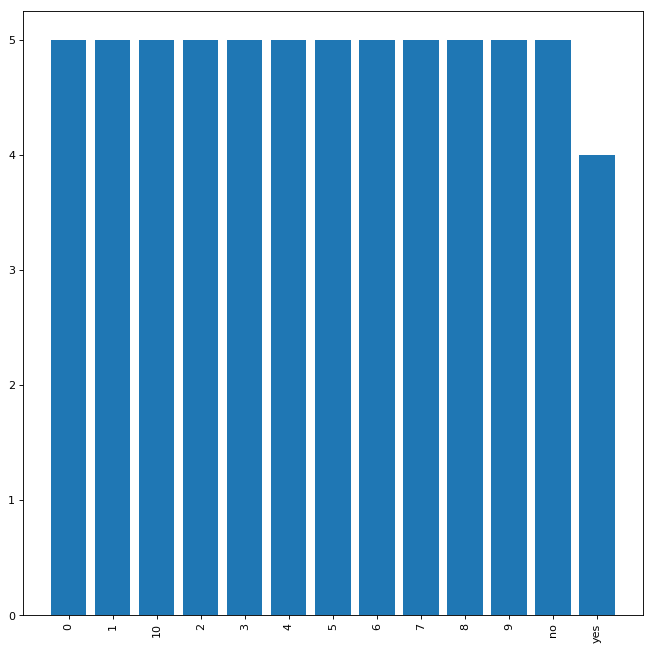


Then the Dataset of each field are recombined via [tf.data.Dataset.zip](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=stable#zip).

## Dataset creation

In [ ]:
# this function returns a dataset for a specific answer
def get_dataset_for_answer(data, ans=None,skip_ans=False, subpath='train', validation_split=0.2, 
                           subset='training', randomize=True):
    # define a filter so as to pick up only a specific type of answer
    def get_answer_selector(ans):
        def answer_selector(el):
            return el['answer']==ans
        return answer_selector
    
    if ans is not None:
        answer_selector = get_answer_selector(ans)
    else:
        answer_selector = None
        
    # dataset containing questions
    # high order function to encode question
    def get_encoder_question(t):
        def question_encoder(text):
            #use tokenizer to encode the sequences
            sequences = t.texts_to_sequences([text.decode("utf-8")])
            sequences = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
            return sequences[0]
        return question_encoder
        
    question_encoder = get_encoder_question(t)
    # obtain the dataset containing questions
    n_elements,dataset_questions = myDataset(data,field='question', 
                             output_shapes     = (MAX_SEQUENCE_LENGTH),
                             output_types      = tf.int32,
                             subset            = subset,
                             funct             = question_encoder, 
                             filt              = answer_selector,
                             validation_split  = validation_split, 
                             seed              = SEED,
                             randomize         = randomize)
    
    # dataset containing answers
    # high order function that encodes the answers with a custom format. 
    # This allows to tackle the problem both as a regression and a classification problem.
    
    def get_answer_encoder(classes):
        def answer_encoder(answer):
            answer = answer.decode('utf-8')
            if(CLASSIFICATION):
                return tf.one_hot([classes.index(answer)], depth=len(classes))[0]
            else:
                res = np.zeros(4)

                if answer == 'yes':
                    res[0] = 1
                elif answer == 'no':
                    res[1] = 1
                else :
                    res[2] = 1
                    res[3] = int(answer)/10

                return res
        return answer_encoder
    answer_encoder = get_answer_encoder(classes)
    # obtain the dataset containing answers
    if not skip_ans:
        _,dataset_answer = myDataset(data,
                                 field='answer', 
                                 output_shapes    = (len(classes)) if CLASSIFICATION else (4) ,
                                 output_types     = tf.float32,
                                 subset           = subset,
                                 funct            = answer_encoder, 
                                 filt             = answer_selector,
                                 validation_split = validation_split, 
                                 seed             = SEED,
                                 randomize         = randomize)

    # dataset containing images
    # high order function that load image from the disk and impose values between [0-1].
    def get_image_loader(basepath):
        def image_loader(path):
            path = os.path.join(basepath ,path.decode("utf-8"))
            img = tf.keras.preprocessing.image.load_img(path)
            
            img = np.array(img)[:,:,:3]

            img = img * 1.0 / 255

            return img
        return image_loader
    PATH_IMAGES = '/kaggle/input/clver-128x192/'
    image_loader = get_image_loader(os.path.join(PATH_IMAGES, subpath))
    # obtain the dataset containing images
    _,dataset_images = myDataset(data,field='image_filename', 
                             output_shapes   = (IMG_HEIGHT, IMG_WIDTH,3),
                             output_types    = tf.float32,
                             subset          = subset,
                             filt            = answer_selector,
                             funct           = image_loader, 
                             validation_split= validation_split, 
                             seed            = SEED,
                             randomize         = randomize)
    
    # ZIP datasets for a given answer
    dataset_res = tf.data.Dataset.zip((dataset_images,dataset_questions))
    if not skip_ans:
        dataset_res = tf.data.Dataset.zip((dataset_res,dataset_answer))
    number_steps = n_elements / batch_size 
    
    print('Number of batches',number_steps)
    # return the dataset for a given answer
    
    return dataset_res, n_elements

# obtain a training/validation dataset for each answer
training_datasets = []
validation_datasets = []
frequency_answers = []
tot_answers = 0
for ans in classes:
    print('obtaining dataset for',ans)
    dataset_ans, _ = get_dataset_for_answer(train_data,ans,subpath='files_clver_train/resized_train', subset='training')
    dataset_ans_val, n_elements = get_dataset_for_answer(train_data, ans, subpath='files_clver_train/resized_train',subset='validation')
    
    frequency_answers.append(n_elements)
    tot_answers += n_elements
    
    training_datasets.append(dataset_ans.shuffle(30).repeat())
    validation_datasets.append(dataset_ans_val)

# combine the datasets together 

frequency_dataset = np.array(frequency_answers) / tot_answers
# if you want to have a train dataset that is not umbalanced toward more frequent questions
frequency_dataset_train = frequency_dataset
    
choice_dataset1 = tf.data.Dataset.range(len(classes)).repeat()
train_dataset_balanced = tf.data.experimental.choose_from_datasets(training_datasets, choice_dataset1).map(lambda x,y: (x,y), num_parallel_calls=20).batch( batch_size,drop_remainder=True)

train_dataset = tf.data.experimental.sample_from_datasets(training_datasets,frequency_dataset_train).map(lambda x,y: (x,y), num_parallel_calls=20).batch( batch_size,drop_remainder=True)

valid_dataset = tf.data.experimental.sample_from_datasets(validation_datasets,frequency_dataset).map(lambda x,y: (x,y), num_parallel_calls=20).batch( batch_size,drop_remainder=False)

# Model architecture

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential

class LuongAttention(tf.keras.layers.Layer):
  def __init__(self):
    super(LuongAttention, self).__init__()

  def call(self, query, values):
    # inputs:
    # -    query comes from LSTM current output
    #      query shape == (batch_size, hidden size)
    # -    values comes from LSTM previous outputs 
    #      values shape == (batch_size, time_steps, hidden size)
    
    # we cannot ensure that these vector comes from the same 
    # LSTM cell, but at least w can ensure that they are compatible
    query = tf.expand_dims(query, axis=1)
    assert ( query.shape[2] == values.shape[2])
    
    # we are doing this to perform mat multiplication , which is 
    # another way to say that every vector inside values has to 
    # be scalarly multiplied with the query vector.
    # note: to avoid discrepncies due to the norm of the vectors
    #       we used normalization which means divide by the product of 
    #       the two norm. We obtain the cosine of the two vectors.
    scores = tf.keras.layers.dot([values, query], axes=2, normalize=True)
    # score shape == (batch_size, sequence_steps, 1)
    attention_weights = tf.nn.softmax(scores, axis=1)
    # attention_weights shape == (batch_size, sequence steps, 1)
    weigthed_values = attention_weights * values
    res             = tf.reduce_sum(weigthed_values, axis=1)

    return attention_weights ,  res

*RNs are architectures whose computations focus explicitly on relational reasoning. Through joint training RNs can influence 
and shape upstream representations in CNNs and LSTMs to produce implicit object-like representations that it can exploit for 
relational reasoning. [https://arxiv.org/pdf/1706.01427.pdf](https://arxiv.org/pdf/1706.01427.pdf)*

In [ ]:
class RN(tf.keras.layers.Layer):
  def __init__(self):
    super(RN, self).__init__()
    self.g = Sequential()
    self.g.add(Dense(256, activation='relu'))
    self.g.add(Dense(256, activation='relu'))
    self.g.add(Dense(256, activation='relu'))
    self.g.add(Dense(256, activation='relu'))
    self.g = tf.keras.layers.TimeDistributed(self.g)
    
    self.f = Sequential()
    self.f.add(Dense(256, activation='relu'))
    self.f.add(Dropout(0.3))
    self.f.add(Dense(256, activation='relu'))
    self.f.add(Dropout(0.3))
  
  def call(self, feature, q):
    # inputs:
    # - feature dimension (batch, height, width ,features_channel )
    objects = []
    relations = []

    k = 35     # Hyperparameter which controls how many objects are considered

    # Get k unique random coordinate inside the feature map
    while k > 0:
        i = np.random.randint(0, feature.shape[1] - 1)
        j = np.random.randint(0, feature.shape[2] - 1)
        if not (i, j) in objects:
            objects.append([i, j])
            k -= 1

    for i in range(len(objects)):
        for j in range(i, len(objects)):
            # Extract feature maps related to those coordinate  
            # combinate those feature vector in every possible manner
            # note: avoided (i,i) due to the fact that we suppose 
            # a reflexive relationship
            coord_1 = objects[i]
            coord_2 = objects[j]
            obj_1 = feature[:,coord_1[0], coord_1[1],:]
            obj_2 = feature[:,coord_2[0], coord_2[1],:] #vector with (batch, feature)
            
            c1 = [2*coord_1[0]/feature.shape[1] -1,2*coord_1[1]/feature.shape[2]-1]
            c2 = [2*coord_2[0]/feature.shape[1] -1,2*coord_2[1]/feature.shape[2]-1]
            c1 = tf.repeat(tf.expand_dims(tf.constant(c1), axis=0),batch_size,axis=0)
            c2 = tf.repeat(tf.expand_dims(tf.constant(c2), axis=0),batch_size,axis=0)

            # Combine those vectors into a single vector with (batch, 2*feature)
            # this would then pass through a dense network
            conc = tf.concat([obj_1, obj_2, q, c1, c2], axis=1)
            #obtain a vector (batch, 1, 2*feature)
            conc = tf.expand_dims(conc, axis=1)
            relations.append(conc)
    # concatenate vectors previously constructed in a vector (batch, k, 2*feature)
    relation_tensor = tf.concat(relations, axis=1)
    scores          = self.g(relation_tensor) # output size (batch, k, #output_neurons_g)
    summation       = tf.reduce_sum(scores, axis=1)
    
    output = self.f(summation)
    return output

In [ ]:
# Attention based on LSTM context and CNN output:
class AttentionFeature(tf.keras.Model):
    def __init__(self, n_features):
        super(AttentionFeature, self).__init__()
        self.EXTRACT = tf.keras.layers.GlobalAveragePooling2D()
        # dense default activation is linear
        self.W1 = tf.keras.layers.Dense(1)
        self.SOFT = tf.keras.layers.Dense(n_features, activation='softmax')

    def call(self, features,hidden):
        # from features and hidden representation to a similarity factor
        mean_activation_per_feature = self.EXTRACT(features)
        hidden_per_feature          = self.W1(hidden)

        # obtain a similarity score
        # tf.multiply supports broadcasting https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
        score = tf.keras.layers.multiply([mean_activation_per_feature, hidden_per_feature])
        attention_weights =  self.SOFT(score)

        features_attentioned = tf.keras.layers.multiply([features, attention_weights])
        features_attentioned = tf.reduce_sum(features_attentioned, axis=3)

        return attention_weights, features_attentioned

In [ ]:
# Attention based on LSTM context and CNN output:
class AttentionFeatureTime(tf.keras.Model):
    def __init__(self, n_features):
        super(AttentionFeatureTime, self).__init__()
        self.EXTRACT = tf.keras.layers.GlobalAveragePooling2D()
        # dense default activation is linear
        self.W1 = tf.keras.layers.Dense(1)
        self.SOFT = tf.keras.layers.Dense(n_features, activation='softmax')

    def call(self, features,hidden):
        # from features and hidden representation to a similarity factor
        feature_seq = []
        mean_activation_per_feature = self.EXTRACT(features)
        for i in range(hidden.shape[1]):
            hidden_per_feature          = self.W1(hidden[:,i,:])

            # obtain a similarity score
            # tf.multiply supports broadcasting https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
            score = tf.keras.layers.multiply([mean_activation_per_feature, hidden_per_feature])
            attention_weights =  self.SOFT(score)

            features_attentioned = tf.keras.layers.multiply([features, attention_weights])
            features_attentioned = tf.reduce_sum(features_attentioned, axis=3)
            feature_seq.append(tf.expand_dims(features_attentioned, axis=-1))
            
        feature_seq = tf.concat(feature_seq, axis=-1)
        return attention_weights, feature_seq

In [ ]:
def get_Vision_Model():
    PRETRAINED = True
    if not PRETRAINED:
        # Define CNN for Image Input
        vision_model = Sequential()
        vision_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
        vision_model.add(MaxPooling2D((2, 2)))
        vision_model.add(BatchNormalization())
        vision_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
        vision_model.add(MaxPooling2D((2, 2)))
        vision_model.add(BatchNormalization())
        vision_model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
        vision_model.add(MaxPooling2D((2, 2)))
        vision_model.add(BatchNormalization())
        return vision_model
    else:
        vision_model = tf.keras.applications.VGG19( include_top=False,weights='imagenet')
        vision_model.trainable = False
        return vision_model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, feature_width*feature_height, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, feature_width*feature_height, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## Model that obtained 0.523

In [ ]:
image_input = Input((IMG_HEIGHT, IMG_WIDTH,3), name='img_input')
vision_output = get_Vision_Model()(image_input)

question_input        = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input', dtype='int32')
embedded_question     = tf.one_hot(question_input,len(words))
#embedded_question     = embedding_layer(question_input)

embedded_question_dim = embedded_question.shape[2]
encoded_question                        = (GRU(embedded_question_dim, return_sequences=True))(embedded_question)
cell_output_history, cell_output_final  = GRU(4*embedded_question_dim, return_sequences=True, return_state=True)(encoded_question)
encoded_question = cell_output_final

encoded_question,_ = BahdanauAttention(30)(cell_output_history, cell_output_final)
vision_output      = tf.keras.layers.Flatten()(vision_output)
encode             = tf.concat([vision_output, encoded_question], axis=1)
dense              = Dense(1024, activation='relu')(encode)
for_head           = Dropout(0.3)(dense)

# head of the NN depending on whether or not the problem was tackled as a mixed classification-regression problem.
if(CLASSIFICATION):
    output = Dense(len(classes), activation='softmax')(for_head)
else:
    output_classification = Dense(3, activation='softmax')(for_head)#3 = [yes, no, regression]
    output_regression     = Dense(1, activation='sigmoid')(for_head)#1 output 
    output = Concatenate()([output_classification, output_regression])

vqa_model = Model(inputs=[image_input, question_input], outputs=output)

## Model with RN

In [ ]:
image_input = Input((IMG_HEIGHT, IMG_WIDTH,3), name='img_input')
vision_output = get_Vision_Model()(image_input)

question_input        = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input', dtype='int32')
embedded_question     = embedding_layer(question_input)

embedded_question_dim = embedded_question.shape[2]

encoded_question                        = (GRU(embedded_question_dim, return_sequences=True))(embedded_question)
cell_output_history, cell_output_final  = GRU(4*embedded_question_dim, return_sequences=True, return_state=True)(encoded_question)
encoded_question = cell_output_final

encoded_question,_ = BahdanauAttention(30)(cell_output_history, cell_output_final)
# Combine CNN and RNN to create the final model
for_head = RN()(vision_output, encoded_question)

# head of the NN
if(CLASSIFICATION):
    output = Dense(len(classes), activation='softmax')(for_head)
else:
    output_classification = Dense(3, activation='softmax')(for_head) #3 = [yes, no, regression]
    output_regression     = Dense(1, activation='sigmoid')(for_head) #1 output unbounded'''

    output = Concatenate()([output_classification, output_regression])

vqa_model = Model(inputs=[image_input, question_input], outputs=output)

In [ ]:
plot_model(vqa_model, show_shapes=True)

In [ ]:
vqa_model.summary()

## Custom loss
Since we decided to tackle the problem as both a classification and regression problem a custom loss was required.

The output of the NN has been encoded as follows:
- binary 1hot encoding 'yes'
- binary 1hot encoding 'no'
- binary 1hot encoding 'regression_problem'
- regression output ranging from 0 to 1 , representing numbers between 0 to 10.

The loss function is a combination of categorical cross entropy and MSE. The MSE term is considered only when the expected answer refer to a counting problem, that is when the third one hot is active. 
inspiration from [FasterRCnn](https://arxiv.org/abs/1506.01497)

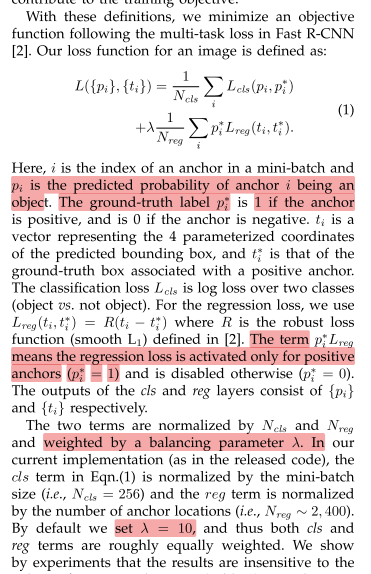

In [ ]:
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.losses import categorical_crossentropy
# Function used to extract categorical and regression term when y related
# to a single sample
def custom_encod2cat_reg(y):
    #ytrue/ypred is made of 4 numbers
    # - binary 1hot encoding 'yes'
    # - binary 1hot encoding 'no'
    # - binary 1hot encoding 'regression_problem'
    # - regression output ranging from 0 to 1 , but representing 0 to 10.
    
    cat, regr = tf.split(y, [3, 1], axis=0)
   
    return cat, regr*10

# Function used to extract categorical and regression term when y related
# to a batch
def custom_encods2cat_reg(y):
    #ytrue/ypred is made of 4 numbers
    # - binary 1hot encoding 'yes'
    # - binary 1hot encoding 'no'
    # - binary 1hot encoding 'regression_problem'
    # - regression output ranging from 0 to 1 , but representing 0 to 10.
    
    cat, regr = tf.split(y, [3, 1], axis=1)
   
    return cat, regr*10

# Custom loss
def loss(y_true, y_pred):
    
    #move from custom encoding to separated component (categorical and regression components)
    cat_y_true, regr_y_true = custom_encods2cat_reg(y_true)
    cat_y_pred, regr_y_pred = custom_encods2cat_reg(y_pred)
    # from t_true categorical extract the 1-hot that express whether the answer
    # was a regression or not for later usage
    
    _, cat_y_true_reg = tf.split(cat_y_true, [2, 1], axis=1)
    w = 1
    # sum the loss of two components categorical and regression
    # regression is only considered when the answer was truly related to regression (counting)
    # inspiration from FasterR-CNN with the loss related to bounding box regression and "objectness" measure
    reg_loss = cat_y_true_reg * w *mean_squared_error(regr_y_true, regr_y_pred)
    
    # reg_loss = cat_y_true_reg *w *tf.keras.losses.mean_absolute_error(regr_y_true, regr_y_pred)
    
    loss = 10/14*categorical_crossentropy(cat_y_true, cat_y_pred) + 4/14*reg_loss
    
    return loss

In [ ]:
# Example of usage
print (loss([[0,0,1,0.1]], [[0,0,1,0.8]]))

print( loss([[0,0,1,0.1]], [[0,0.9,0,0.8]]))

## Custom metric
Since the encoding differs from the one used to evaluate the work on kaggle we have to
return to the original encoding before supply the tensors to categorical_accuracy function.


In [ ]:
from tensorflow.keras.metrics import categorical_accuracy
# Function used to move from custom encoding back to the original encoding used in 
# the Kaggle competition. Used in case y relates to a single sample
def custom_encod2cat(y):
    # extract categorical and regression terms out of the custom encoding
    cat_y, regr_y = custom_encod2cat_reg(y)
    # separate in from the categorical part of the output the one hot related to 
    # - indicates yes 
    # - indicates no
    # - indicates a regression
    cat_yes, cat_no ,cat_regr= tf.split(cat_y, [1,1,1], axis=0)
    
    # move from regression output to one hot between 11 classes
        
    regr_one_hot = tf.reshape(tf.one_hot( tf.cast(tf.math.round(regr_y), tf.uint8), 11), [-1])
    # multiply with one hot that indicates whether this was a regression problem or not
    # so as to eliminate regression one hot in case cat_regr is low
    regr_one_hot = cat_regr * regr_one_hot
    
    # rearrange one hots to reflect the output expected by the kaggle competition    
    reg_01, regr_29 ,regr_10= tf.split(regr_one_hot, [2,8,1], axis=0)
    categorical = tf.concat([reg_01, regr_10, regr_29, cat_no, cat_yes ], axis=0)
   
    return categorical

# Function used to move from custom encoding back to the original encoding used in 
# the Kaggle competition. Used in case y relates to a batch
def custom_encods2cat(ys):
    
    return tf.map_fn(custom_encod2cat, ys)
    

# custom metric "adapter"
def metric(y_true, y_pred):
    
    y_true = custom_encods2cat(y_true)
    y_pred = custom_encods2cat(y_pred)
    
    return categorical_accuracy(y_true, y_pred)

In [ ]:
# test of usage
for p in range(1,11):
    for num in range(11):
        assert np.argmax(custom_encod2cat([p/10 -0.1,p/10-0.1,p/10,num/10])) == classes.index(str(num)) 

In [ ]:
# Optimization parameters

lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [metric]
# Compile Model (change the name for each model)
if(CLASSIFICATION):
    vqa_model.compile(optimizer=optimizer, loss=tf.keras.losses.categorical_crossentropy, metrics=[tf.keras.metrics.categorical_accuracy])
else:
    vqa_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
#train first with a balanced dataset

history = vqa_model.fit(
              train_dataset_balanced.prefetch(tf.data.experimental.AUTOTUNE),
              steps_per_epoch = 400,
              epochs=10,
              validation_freq = 1,
              validation_data=valid_dataset.prefetch(tf.data.experimental.AUTOTUNE),
              validation_steps = 30
          )

In [ ]:
# Fine tune the architecture with a dataset that reflect the class imbalance in the data.
history = vqa_model.fit(
              train_dataset.prefetch(tf.data.experimental.AUTOTUNE),
              steps_per_epoch = 400,
              epochs=60,
              validation_freq = 1,
              validation_data=valid_dataset.prefetch(tf.data.experimental.AUTOTUNE),
              validation_steps = 40
          )

In [ ]:
vqa_model.evaluate(valid_dataset)

# Evaluate results

In [ ]:
# Code snippet used in a first time to evaluate
# models' capabilities. In particular was used to try spotting correlations
# between errors both on the training and on the validation dataset.

def computeConfusion(dataset, max_num ):
    confusion_matrix = [[ 0 for i in range(0,len(classes))] for i in range(0,len(classes))];

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        sample = batch[0]
        labels = batch[1]
        for j,l in enumerate(labels):

            if(i > max_num):
                break;
    
            res = vqa_model.predict((tf.expand_dims(sample[0][j], axis=0), tf.expand_dims(sample[1][j], axis=0)) )
            if not CLASSIFICATION:
                l = custom_encod2cat(l)
                res = custom_encods2cat(res)
                
            expected = np.argmax(l)
            predicted = np.argmax(res[0]);
            
            confusion_matrix[expected][predicted] +=1
            i+=1

    plotConfusionMatrix(confusion_matrix);
      
def plotConfusionMatrix(conf):
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    im = plt.imshow(conf)
    plt.yticks(range(0,len(classes)), labels=classes);
    plt.xticks(range(0,len(classes)), labels=classes, rotation='vertical' );
    plt.ylabel("expected");
    plt.xlabel("predicted");
    plt.gca().invert_yaxis()
    plt.colorbar();

    for y in range(len(conf)):
        for x in range(len(conf[y])):
            plt.text(x, y , '{:.0f}'.format(conf[y][x]),
                  color='w',horizontalalignment='center',
                  verticalalignment='center')


computeConfusion(train_dataset, 400);
computeConfusion(valid_dataset, 400);

In [ ]:
# The following code snippet was used to have an idea on 
# dataset distribution across the classes.
def plotDatasetDistribution(dataset, max_num ):
    classes_count = [0 for i in range(len(classes))]

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        labels = batch[1]
        for l in labels:
            if(i > max_num):
                break
            if not CLASSIFICATION:
                l = custom_encod2cat(l)
            expected = np.argmax(l)
            classes_count[expected]+=1
            i+=1
    #print(classes_count)
    plt.figure( figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k');
    plt.bar(range(len(classes)), classes_count )
    plt.xticks( ticks=range(len(classes)) ,labels=classes, rotation='vertical' )
    plt.show()

plotDatasetDistribution(train_dataset, 400)
plotDatasetDistribution(valid_dataset, 400)

# Collecting results

In [ ]:
# We can obtain a dataset in the same way we have done for the training_testset
dataset_test,_ = get_dataset_for_answer(test_data,ans=None, skip_ans=True, subpath='files_clver_test/resized_test',
                                      subset='training', validation_split=0.0, randomize=False)
# Keras conventions require that inputs to model predict are
# tuples (input, None)
# in our specific case
# tuples ( (img_input, text_input) , None)
dataset_test = tf.data.Dataset.zip((dataset_test,)).batch(batch_size)

In [ ]:
# predict from dataset
answers = vqa_model.predict(dataset_test)
# answers is a vector of outputs 

In [ ]:
print('answers',answers[:4])
# a fast check that all answers have been all collected
assert(len(answers) == len (test_data))

# if the model had a custom encoding we have to translate
# back the vector to what would be produced by a classification network
if not CLASSIFICATION:
    cat_anwers = custom_encods2cat(answers)
else:
    cat_anwers = answers
    
print('categorized',cat_anwers[:4])
num_answers = tf.argmax(cat_anwers,axis=1)
print(num_answers[:4])
print(len(num_answers), len(test_data))
assert(len(num_answers) == len (test_data))

results = {}
for i,el in enumerate(num_answers):
    results[i] = el.numpy()
    
res_bin = np.zeros(len(classes))
for k in results:
    res_bin[results[k]] +=1

%52.3 
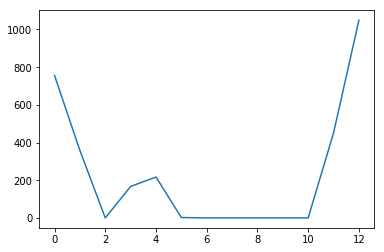

%44
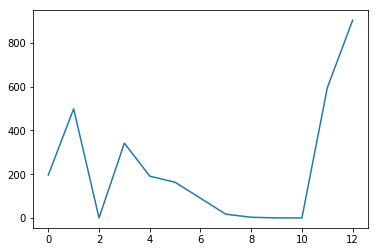

%46 accuracy
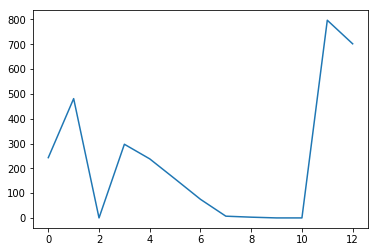

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(str(key) + ',' + str(value) + '\n')

create_csv(results)